# Pre-Processing the Data

In [10]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle

# Load datasets
df1 = pd.read_csv("./data/student_dataset.csv")
df2 = pd.read_csv("./data/scholarship_dataset.csv")

# Merge datasets
df3 = df1.merge(df2, how='cross')

# Function to generate target variable
def generate_output(row):
    if (((row['Education_Level'],row['Scholarship_Level'])==('BS','Masters')) |
        ((row['Education_Level'],row['Scholarship_Level'])==('Masters','PhD')) |
        ((row['Education_Level'],row['Scholarship_Level'])==('PhD','PhD'))) | ((row['Country_Preference'] == row['Country_of_Scholarship']) |
                                                                              (row['Domain_Area'] == row['Eligible_Domain'])):
        return 1
    else:
        return 0

df3['Target'] = df3.apply(generate_output, axis=1)

# Drop unnecessary columns
df3.drop(['Name', 'CGPA', 'Budget_Prefrence', 'Scholarship_Name', 'Scholarship_Type', 'Scholarship_Budget', 'Required_GPA'], axis=1, inplace=True)

# Save merged dataset
df3.to_csv("combined_dataset.csv", index=False)

print(df3['Target'].value_counts())

# Load the dataset
df3 = pd.read_csv("combined_dataset.csv")

# Initialize a dictionary to store label encoders for each column
label_encoders = {}

# Apply label encoding to each categorical column separately
for col in df3.select_dtypes(include=['object']).columns:
    label_encoder = LabelEncoder()
    df3[col] = label_encoder.fit_transform(df3[col])
    label_encoders[col] = label_encoder

# Split the dataset into features (X) and target variable (y)
X = df3.drop('Target', axis=1)
y = df3['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Target
0    128549
1    121451
Name: count, dtype: int64


# Training the Model

In [15]:
# Build a simple neural network model
model = Sequential([
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with a specified number of epochs
epochs = 10  # Adjust the number of epochs as needed
history = model.fit(X_train_scaled, y_train, epochs=epochs, validation_data=(X_test_scaled, y_test))

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7202 - loss: 0.5608 - val_accuracy: 0.8654 - val_loss: 0.3351
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8669 - loss: 0.3356 - val_accuracy: 0.8751 - val_loss: 0.3262
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8720 - loss: 0.3277 - val_accuracy: 0.8708 - val_loss: 0.3257
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8729 - loss: 0.3254 - val_accuracy: 0.8734 - val_loss: 0.3222
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8731 - loss: 0.3247 - val_accuracy: 0.8794 - val_loss: 0.3192
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8771 - loss: 0.3189 - val_accuracy: 0.8772 - val_loss: 0.3177
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8786 - loss: 0.3164 - val_accuracy: 0.8799 - val_loss: 0.3147
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8777 - loss: 0

# Evaluating the Model

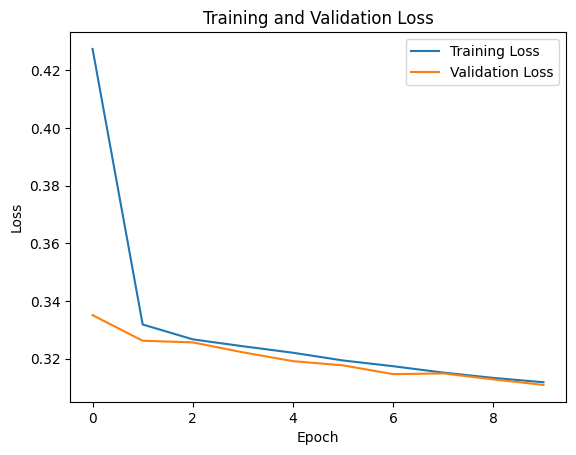

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8805 - loss: 0.3103
Accuracy: 0.8798999786376953
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     25702
           1       0.99      0.76      0.86     24298

    accuracy                           0.88     50000
   macro avg       0.90      0.88      0.88     50000
weighted avg       0.90      0.88      0.88     50000

Confusion Matrix:
[[25531   171]
 [ 5834 18464]]


In [16]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
_, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Saving the Model

In [18]:
# Save the model
model.save("my_model.h5")

# Save label encoders to disk
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Making the Predictions

In [19]:
df3.head()

,Education_Level,Country_Preference,Domain_Area,Scholarship_Level,Country_of_Scholarship,Eligible_Domain,Target
0,0,1,0,2,2,6,0
1,0,1,0,1,2,6,1
2,0,1,0,1,3,12,1
3,0,1,0,2,5,12,0
4,0,1,0,2,1,8,1


In [20]:
for col, label_encoder in label_encoders.items():
    print(f"Column: {col}")
    print(list(label_encoder.classes_))
    print()

Column: Education_Level
['BS', 'Masters', 'PhD']

Column: Country_Preference
['Australia', 'Canada', 'Pakistan', 'UK', 'USA', 'United Kingdom', 'United States']

Column: Domain_Area
['Business Administration', 'CS', 'Chemistry', 'Computer Science', 'Electrical Engineering', 'Finance', 'Fine Arts', 'History', 'Medical Research', 'Medical Science', 'Physics', 'SE', 'Software Engineering']

Column: Scholarship_Level
['BS', 'Masters', 'PhD']

Column: Country_of_Scholarship
['Australia', 'Canada', 'Pakistan', 'UK', 'USA', 'United Kingdom', 'United States']

Column: Eligible_Domain
['Business Administration', 'CS', 'Chemistry', 'Computer Science', 'Electrical Engineering', 'Finance', 'Fine Arts', 'History', 'Medical Research', 'Medical Science', 'Physics', 'SE', 'Software Engineering']



In [21]:
# Load the saved model
loaded_model = load_model("my_model.h5")

# Load label encoder from disk
with open("label_encoders.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Load the scaler
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Sample raw data
raw_data = pd.DataFrame({
    'Education_Level': ['BS'],
    'Country_Preference': ['USA'],
    'Domain_Area': ['Business Administration'],
    'Scholarship_Level': ['Masters'],
    'Country_of_Scholarship': ['USA'],
    'Eligible_Domain': ['Computer Science'],
})

# Initialize an empty DataFrame to store encoded raw data
encoded_raw_data = pd.DataFrame()

# Encode categorical features in the raw data using the loaded label encoders
for col in raw_data.columns:
    if col in label_encoder:
        label_encoder_col = label_encoder[col]
        encoded_raw_data[col] = label_encoder_col.transform(raw_data[col])

# Scale the encoded raw data using the loaded scaler
scaled_raw_data = scaler.transform(encoded_raw_data)

# Make predictions with the loaded model
predictions = loaded_model.predict(scaled_raw_data)

# Set the threshold
threshold = 0.5

# Apply threshold to convert probabilities to class labels
binary_predictions = (predictions > threshold).astype(int)

# Display the class labels
print("Class Labels (Predictions):")
print(binary_predictions[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Class Labels (Predictions):
1
